# Overview
In this notebook we'll create some analytics around a subreddit. Our goal will be to keep it functional so we can use it for data extraction on demand.  
$$\text{analyze}(\text{subreddit_name})->\text{metrics}$$  
We're going to focus on tracking the top linked websites on a given subreddit. First we'll access a subreddit, pull posts, and then go over comment parsing. You can extend this to work on any collection of things. For example, a group of subreddits, a reddit user, or other data sources that aren't reddit.

## Traversal

In [7]:
from secret_services import reddit

subreddit_name="learnpython"
subreddit=reddit.subreddit(subreddit_name)

#Can change window size(s) to compare top links over tiem
for post in subreddit.top("week",limit=10):
    post
#I write my logic iteratively, having a blank for loop makes it easier to fill in later
#   without creating annoying temp vars outside of your control logic (the for loop)

In [8]:
#Comment Forest!?!
#https://praw.readthedocs.io/en/stable/code_overview/other/commentforest.html
post.comments

## What's a comment forest?
For this refer to the docs, [comment forest - PRAW DOCS](https://praw.readthedocs.io/en/stable/code_overview/other/commentforest.html).  
  
Essentially a comment forest is a tree of results, the top of the tree is the post and there are various sub-trees, "top-level", comments below that. Viewed horizontally:
```
post (lvl 0 -- root)
 |  comment 1 (lvl 1)
 |  |  sub comments (lvl 2)
 |  |  sub comments
 |  |  |  More sub comments (lvl 3)
 |  comment 2
 |  ...
 
```
  
To get a better feel for traversals and seeing a reddit post more commonly our first task will be to output a post in this format.

In [9]:
def output_tree(submission):
    #TODO
    pass

In [16]:
post

Submission(id='pqcp6b')

In [198]:
#I'll hardcode the url I found when running this so you can follow along
post=reddit.submission('pqcp6b')
print(post.url)

https://www.reddit.com/r/learnpython/comments/pqcp6b/beginner_looking_for_ways_to_grind/


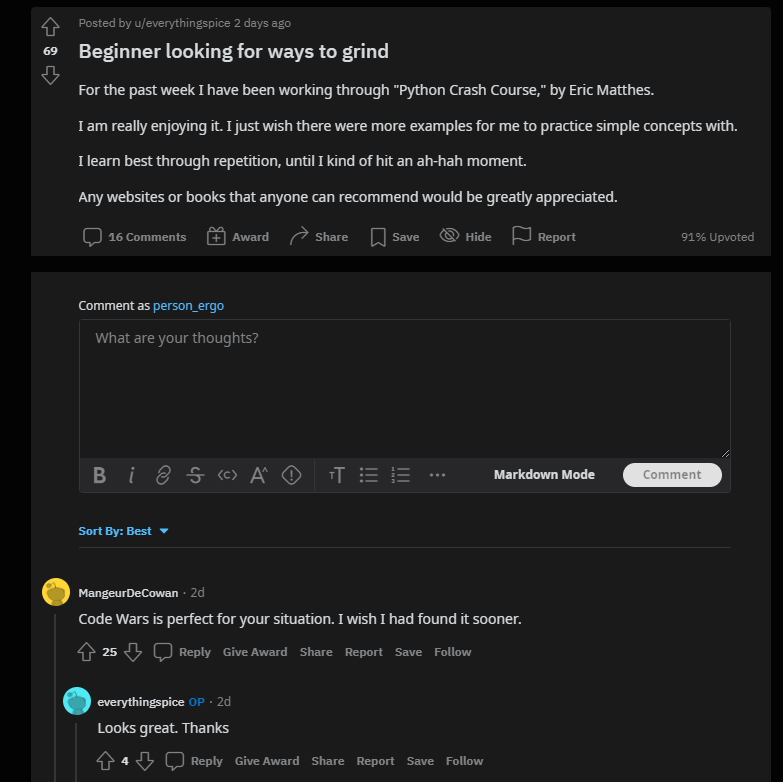

In [199]:
post.comments[0].body#Looks like it matches up!

'Code Wars is perfect for your situation. I wish I had found it sooner.'

In [200]:
#Post viewer
print("POST:")
print(post.title)
print(post.selftext)
print(post.url)
print("------------------\n\n")

for comment in post.comments:
    s=f"{comment.body}"
    print(s)
    for r in comment.replies:
        s="  |"
        s+=r.body
        print(s)
    print()

POST:
Beginner looking for ways to grind
For the past week I have been working through "Python Crash Course," by Eric Matthes.

I am really enjoying it. I just wish there were more examples for me to practice simple concepts with.

I learn best through repetition, until I kind of hit an ah-hah moment.

Any websites or books that anyone can recommend would be greatly appreciated.
https://www.reddit.com/r/learnpython/comments/pqcp6b/beginner_looking_for_ways_to_grind/
------------------


Code Wars is perfect for your situation. I wish I had found it sooner.
  |Looks great. Thanks
  |Thanks for this - python beginner here!
  |Hackerank is also pretty beginner friendly

See https://www.reddit.com/r/learnpython/wiki/index for more resources. I'd recommend Exercism, which is more beginner friendly than Codewars.
  |This. I like the concept of code wars a lot, I'm just not there yet, but can't wait to be. Thanks!

Hey, a bit bit far from what you were asking, but I would recommend you that t

## Improvements
The post viewer kind of works but has a few issues.  
- What if we want to output more info about a comment? 
- The traversal only goes to the 3rd level and will miss comments deeper than that

We'll solve this by using "recursion" to go through the entire post. Then we can write a function on each comment for representing it if we so choose.

In [201]:
#Depth first search (go deep first then go next). https://en.wikipedia.org/wiki/Tree_traversal
# In reality a breadth first search may be better if we don't want to parse everything
def traverse_post(post):
    comments=[]
    for comment in post.comments:
        comments+=recursive_replies(comment, level=1)
    return comments

def recursive_replies(reply,level):
    #Also return level in case we want to stop after level 3 comments and for ease of the printing 
    comments=[(reply, level)]
    for r in reply.replies:
        comments+=recursive_replies(r,level+1)
    return comments
comments=traverse_post(post)
comments

[(Comment(id='hda387e'), 1),
 (Comment(id='hda5l9c'), 2),
 (Comment(id='hdb5hob'), 2),
 (Comment(id='hdcw1s3'), 2),
 (Comment(id='hdamp27'), 1),
 (Comment(id='hdclh3c'), 2),
 (Comment(id='hdaywv9'), 1),
 (Comment(id='hdclkz4'), 2),
 (Comment(id='hdd28wf'), 3),
 (Comment(id='hdcre3e'), 2),
 (Comment(id='hdaw5vg'), 1),
 (Comment(id='hda68ph'), 1),
 (Comment(id='hdcly7v'), 2),
 (Comment(id='hdaagra'), 1),
 (Comment(id='hdan291'), 1),
 (Comment(id='hdcwfon'), 1)]

In [202]:
def output_post(post):
    prefix="  |"
    #Post viewer Improved!
    print(f"POST: {post.title}")
    print()
    print(post.selftext)
    print(post.url)
    print("------------------\n\n")
    comments=traverse_post(post)
    for c,level in comments:
        s=f"{level*prefix} {c.body}"
        print(s)
output_post(post)

POST: Beginner looking for ways to grind

For the past week I have been working through "Python Crash Course," by Eric Matthes.

I am really enjoying it. I just wish there were more examples for me to practice simple concepts with.

I learn best through repetition, until I kind of hit an ah-hah moment.

Any websites or books that anyone can recommend would be greatly appreciated.
https://www.reddit.com/r/learnpython/comments/pqcp6b/beginner_looking_for_ways_to_grind/
------------------


  | Code Wars is perfect for your situation. I wish I had found it sooner.
  |  | Looks great. Thanks
  |  | Thanks for this - python beginner here!
  |  | Hackerank is also pretty beginner friendly
  | See https://www.reddit.com/r/learnpython/wiki/index for more resources. I'd recommend Exercism, which is more beginner friendly than Codewars.
  |  | This. I like the concept of code wars a lot, I'm just not there yet, but can't wait to be. Thanks!
  | Hey, a bit bit far from what you were asking, but I

There are still a few issues with how new lines are handled and word wrapping but this is good enough for now. Back onto the more fun part, the analytics.

## Link Recognition
So we've taken the Reddit API and used it to create a list of comments from a post. We also can get posts from a given subreddit. Now we've got just about all we need to bring in link recognizing code. Let's do it!


In [203]:
def get_post_text(post):
    if post.selftext:
        return post.selftext
    else:
        return post.url

In [204]:
def extract_link_information(text):
    #Notice that this function works off of text, it can be used for other data scraping too!
    #In general make functions as reusable as makes sense
    data={}
    return data

comments=traverse_post(post)
rows=[]
rows.append(extract_link_information(get_post_text))
for comment,level in comments:
    row=extract_link_information(comment.body)
    rows.append(row)
rows

[{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]

In [205]:
example_with_url="See https://www.reddit.com/r/learnpython/wiki/index for more resources. I'd recommend Exercism, which is more beginner friendly than Codewars."
example_without_url="Nothing to see here"

In [206]:
#using the built in urlparse library and regex
from urllib.parse import urlparse  #https://docs.python.org/3/library/urllib.parse.html
import re #Regex is generally available in all programming languages

#Stack Overflow is handy when you are solving common problems
#https://stackoverflow.com/a/9760660
re.findall(r'(https?://[^\s]+)', example_with_url)

['https://www.reddit.com/r/learnpython/wiki/index']

In [207]:
re.findall(r'(https?://[^\s]+)', example_without_url)

[]

In [208]:
parsed_url=urlparse('https://www.reddit.com/r/learnpython/wiki/index')
parsed_url


ParseResult(scheme='https', netloc='www.reddit.com', path='/r/learnpython/wiki/index', params='', query='', fragment='')

Think about what data you want then add it in. I'd like to store the root domain (www.reddit.com and another one with the full url path without any params /1/, queryargs ?arg1=test, or anything else

In [209]:
from collections import defaultdict

def extract_link_information(text):
    #Notice that this function works off of text, it can be used other data scraping projects too!
    #In general make functions as reusable as makes sense
    root_domains=defaultdict(int)
    if text:
        urls=re.findall(r'(https?://[^\s]+)', text)
        for url in urls:
            parsed_url=urlparse(url)
            root_domains[parsed_url.netloc]+=1    
    return root_domains



all_domains=defaultdict(int)
comments=traverse_post(post)
texts=[get_post_text(post)]+[comment.body for comment,level in comments]
for text in texts:
    domains=extract_link_information(text)
    for k,v in domains.items():
        all_domains[k]+=v
all_domains

defaultdict(int, {'www.reddit.com': 1})

## Tying it all together
We've done it for one post, let's now do for multiple posts

In [210]:
def get_domains(post):
    all_domains=defaultdict(int)
    comments=traverse_post(post)
    texts=[get_post_text(post)]+[comment.body for comment,level in comments]
    for text in texts:
        domains=extract_link_information(text)
        for k,v in domains.items():
            all_domains[k]+=v
    return all_domains

subreddit_name="learnpython"
subreddit=reddit.subreddit(subreddit_name)

#Can change window size(s) to compare top links over tiem
for post in subreddit.top("week",limit=10):
    get_domains(post)

AttributeError: 'MoreComments' object has no attribute 'replies'

In [211]:
#Uh oh, found a bug. Let's investigate and fix. I've hardcoded the submission ID but the for loop crashes on it exactly too
post=reddit.submission("pp9fsx")
post

Submission(id='pp9fsx')

In [212]:
from praw.models import MoreComments

In [213]:
#Improved version that fixes the MoreComments bug
def traverse_post(post):
    comments=[]
    for comment in post.comments:
        comments+=recursive_replies(comment, level=1)
    return comments

def recursive_replies(reply,level):
    #Also return level in case we want to stop after level 3 comments and for ease of the printing 
    comments=[]
    #Funky MoreComments code checked manually with permalinks and seems right
    if isinstance(reply, MoreComments):#https://praw.readthedocs.io/en/stable/code_overview/models/more.html
        replies=reply.comments()
        level-=1
    else:
        replies=reply.replies
        comments+=[(reply, level)]
    for r in replies:
        comments+=recursive_replies(r,level+1)
    return comments
comments=traverse_post(post)
comments

[(Comment(id='hd22dpg'), 1),
 (Comment(id='hd22yqh'), 2),
 (Comment(id='hd4ia3c'), 2),
 (Comment(id='hd4rytm'), 3),
 (Comment(id='hd4vo5u'), 3),
 (Comment(id='hd4fubp'), 2),
 (Comment(id='hd2atci'), 1),
 (Comment(id='hd2cl8r'), 2),
 (Comment(id='hd4d964'), 2),
 (Comment(id='hd4s0g8'), 2),
 (Comment(id='hd3es46'), 1),
 (Comment(id='hd3vt24'), 2),
 (Comment(id='hd41ngp'), 2),
 (Comment(id='hd22jbx'), 1),
 (Comment(id='hd23jrt'), 2),
 (Comment(id='hd23m0k'), 3),
 (Comment(id='hd23q0r'), 4),
 (Comment(id='hd23w0q'), 5),
 (Comment(id='hd28t25'), 5),
 (Comment(id='hd2aemd'), 6),
 (Comment(id='hd2hqvl'), 7),
 (Comment(id='hd2ig73'), 8),
 (Comment(id='hd2klxm'), 9),
 (Comment(id='hd35wt3'), 10),
 (Comment(id='hd38sro'), 11),
 (Comment(id='hd4yz58'), 10),
 (Comment(id='hd53nrm'), 10),
 (Comment(id='hd23koa'), 2),
 (Comment(id='hd22go5'), 1),
 (Comment(id='hd239ss'), 2),
 (Comment(id='hd2t23o'), 3),
 (Comment(id='hd2vs3q'), 4),
 (Comment(id='hd2krhk'), 1),
 (Comment(id='hd2n2yc'), 2),
 (Comment(

## Code Quality
Phew looks like I fixed it. Thankfully we aren't writing this code for NASA and errors are OK. The majority of important links should be farther "up" the comment forest and not run into the more comments error so I'm OK with this quality for now. I did verify it looks right but checking for all the edgecases right now is overkill and not a major value add to the analytics portion. Sometimes errors like this can be more important but thankfully this isn't a mission critical code piece

In [214]:
#Runnable function
def analyze_subreddit(subreddit_name):
    subreddit=reddit.subreddit(subreddit_name)

    all_domains=defaultdict(int)
    #Can change window size(s) to compare top links over tiem
    for post in subreddit.top("week",limit=10):
        domains=get_domains(post)
        for k,v in domains.items():
            all_domains[k]+=v
    return {"domains": all_domains}
analyze_subreddit("learnpython")

{'domains': defaultdict(int,
             {'help.kite.com': 1,
              'www.youtube.com': 1,
              'twitter.com': 1,
              '0.30000000000000004.com': 1,
              'docs.python.org': 9,
              'en.wikipedia.org': 8,
              'www.reddit.com': 8,
              'youtu.be': 3,
              'www.w3schools.com': 5,
              'stackoverflow.com': 4,
              'en.m.wikipedia.org': 1,
              'asciinema.org': 1,
              'c.tenor.com': 1,
              'xkcd.com': 2,
              'reddit.com': 2,
              'np.reddit.com': 3,
              'github.com': 3,
              'www.explainxkcd.com': 1,
              'old.reddit.com': 1,
              'uvmbored.com': 1,
              'www.python.org': 4,
              'mypy.readthedocs.io': 1,
              'pylint.pycqa.org': 1,
              'stalas.alm.lt': 2,
              'black.vercel.app': 1,
              'realpython.com': 1,
              'm.youtube.com': 1,
              'inventw

# Wrapping up
Well, we've got our domains but it looks like there are still some things to be fixed around url combining. *reddit should be combined as well as youtube and a few others. 
  
In the next tutorial I'll go over cleaning this data so we can use the results better.  
  
As we continue with our reddit analytic I'll add functionality to the analyze_subreddit command. We can add things like top phrases, argumentiveness score, or anything else that makes sense. Bundling together in one function will make it nice to run on demand if you are trying to get a feel for the subreddit culture.